In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import shutil
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
resnet 
from tensorflow.keras import layers
from tensorflow.keras import Model

In [41]:
finding = "Cardiomegaly"

In [42]:
df = pd.read_csv('labels.csv')
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [43]:
positives = df.loc[df['label'] == finding]
negatives = df.loc[df['label'] == "No Finding"]
n = len(positives)
print(n)

146


In [44]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
TRAIN_N = int(n * TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [45]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_lables = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [46]:
rootdir = "D:/HEC/New Project/Medical Image/"
os.makedirs(rootdir+finding+"/test/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [47]:
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+'images/'+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+'images/'+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+'images/'+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:TRAIN_N+30].iterrows():
  source = rootdir+'images/'+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

In [48]:
def load_image_into_numpy_array(image):
    return np.array(image)

positive_image, negative_image = [], []
image_hight, image_width = 256, 256
for idx, row in positives[:6].iterrows():
  image_path = rootdir+'images/'+row["filename"]
  image = Image.open(image_path).resize((image_hight, image_width))
  positive_image.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
    image_path = rootdir+'images/'+row["filename"]
    image = Image.open(image_path).resize((image_hight, image_width))
    negative_image.append(load_image_into_numpy_array(image))



Text(0.5, 0.98, 'Cardiomegaly')

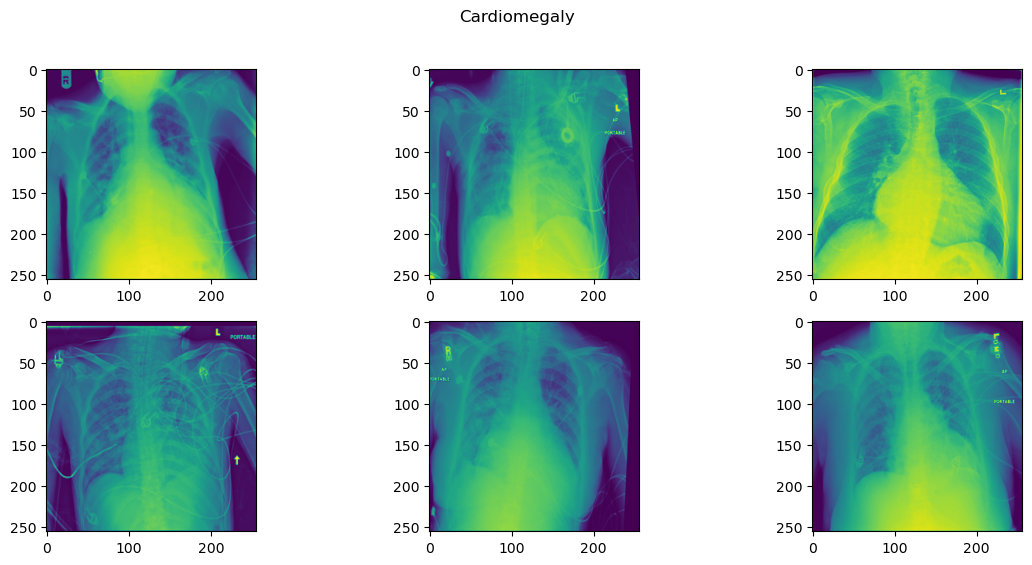

In [49]:
# for idx, img in enumerate(positive_image[:6]):
#     plt.subplot(2,3,idx+1)
#     plt.title("finding")
#     plt.imshow(positive_image[idx])
# plt.show()
# for idx, img in enumerate(negative_image[:6]):
#     plt.subplot(2,3,idx+1)
#     plt.title("No finding")
#     plt.imshow(negative_image[idx])
# plt.show()
plot_object1 = plt.subplots(nrows=2, ncols=3, figsize = (14, 6))
fig, ((axA, axB, axC), (axD, axE, axF)) = plot_object1
axA.imshow(positive_image[0])
axB.imshow(positive_image[1])
axC.imshow(positive_image[2])
axD.imshow(positive_image[3])
axE.imshow(positive_image[4])
axF.imshow(positive_image[5])
plt.suptitle('Cardiomegaly')


In [50]:
pre_trained_model = InceptionV3(input_shape = (image_hight, image_width, 3), weights = 'imagenet', include_top = False)

for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)  # Apply the Dropout layer correctly
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])


In [51]:
# Add our Data-augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [52]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
rotation_range = 40,
width_shift_range = 2.0,
height_shift_range = 0.2,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = False)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [53]:
# Define our example directories and files 
base_dir = rootdir = "D:/HEC/New Project/Medical Image/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')


train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir =  os.path.join(train_dir, 'negative')
#test_pos_dir =  os.path.join(test_dir, 'positive')
test_neg_dir =  os.path.join(test_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')

In [54]:
print(test_pos_dir)

D:/HEC/New Project/Medical Image/Cardiomegaly\test\positive


In [55]:

# import matplotlib.image as mpimg

# # List all files in the directory
# image_files = os.listdir(test_pos_dir)

# # Visualize each image
# for image_file in image_files:
#     # Construct the full path to the image
#     image_path = os.path.join(test_pos_dir, image_file)
    
#     # Load and display the image
#     img = mpimg.imread(image_path)
#     plt.imshow(img)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()


In [56]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [57]:
print(test_pos_dir)

D:/HEC/New Project/Medical Image/Cardiomegaly\test\positive


In [58]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (image_width, image_hight),
    batch_size = 1,
    class_mode = 'binary'
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size = (image_width, image_hight),
    batch_size = 1,
    class_mode = 'binary')
train_steps = len(os.listdir(train_pos_dir))*2
test_steps = len(os.listdir(test_pos_dir))*2


Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [59]:
#os.listdir(train_pos_dir)
# len(os.listdir(train_pos_dir))

In [60]:
# len(os.listdir(test_pos_dir))

In [61]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (image_width, image_hight),
    batch_size = 1,
    class_mode = 'binary'
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size = (image_width, image_hight),
    batch_size = 1,
    class_mode = 'binary')
train_steps = len(os.listdir(train_pos_dir))*2
test_steps = len(os.listdir(test_pos_dir))*2


Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Run Model

In [62]:
histroy = model.fit(
    train_generator, 
    steps_per_epoch = train_steps,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = test_steps,
    verbose = 2
)

Epoch 1/10


232/232 - 488s - loss: 11.4786 - acc: 0.5991 - val_loss: 6.2960 - val_acc: 0.5000 - 488s/epoch - 2s/step
Epoch 2/10
232/232 - 439s - loss: 2.9767 - acc: 0.6293 - val_loss: 0.4902 - val_acc: 0.7500 - 439s/epoch - 2s/step
Epoch 3/10
232/232 - 3955s - loss: 1.4393 - acc: 0.6164 - val_loss: 0.3560 - val_acc: 0.8667 - 3955s/epoch - 17s/step
Epoch 4/10
232/232 - 547s - loss: 0.6531 - acc: 0.7284 - val_loss: 0.3725 - val_acc: 0.8000 - 547s/epoch - 2s/step
Epoch 5/10
232/232 - 509s - loss: 0.6230 - acc: 0.7457 - val_loss: 1.0229 - val_acc: 0.5000 - 509s/epoch - 2s/step
Epoch 6/10
232/232 - 489s - loss: 0.5622 - acc: 0.7328 - val_loss: 0.6054 - val_acc: 0.6500 - 489s/epoch - 2s/step
Epoch 7/10
232/232 - 558s - loss: 0.5178 - acc: 0.7759 - val_loss: 0.5304 - val_acc: 0.7333 - 558s/epoch - 2s/step
Epoch 8/10
232/232 - 347s - loss: 0.5284 - acc: 0.7586 - val_loss: 0.4715 - val_acc: 0.7667 - 347s/epoch - 1s/step
Epoch 9/10
232/232 - 338s - loss: 0.5555 - acc: 0.7026 - val_loss: 0.4153 

In [86]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            


                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 125, 125, 32)         9216      ['activation[0][0]']          
                                                                                                  
 batch_nor

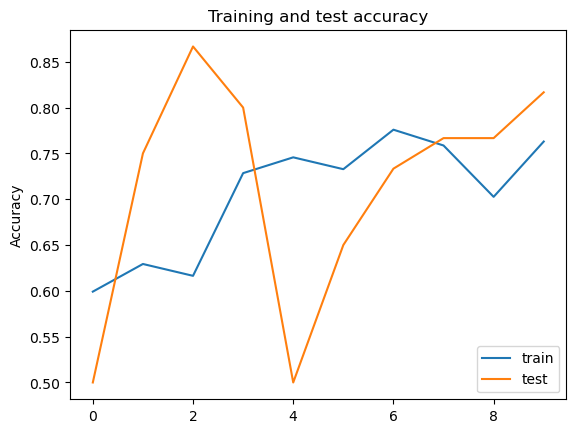

In [80]:
acc = histroy.history['acc']
val_acc = histroy.history['val_acc']
loss = histroy.history['loss']
val_loss = histroy.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label = 'train')
plt.plot(epochs, val_acc, label = 'test')
plt.ylabel("Accuracy")
plt.title("Training and test accuracy")
plt.legend(loc = "lower right")

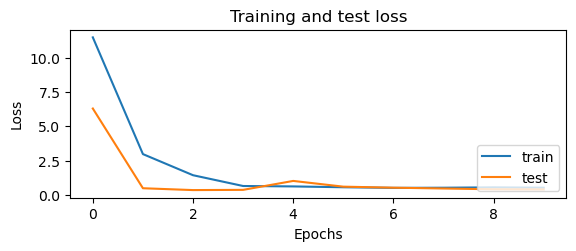

In [78]:
plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


# Evaluating Performance

In [81]:
# def predict_image(filename):
#     image = Image.open(filename).resize((image_hight, image_width))
#     image_np = load_image_into_numpy_array(image)
#     exp = np.true_divide(image_np,255.0)
#     expanded = np.expand_dims(exp, axis = 0)
    # return model.predict(expanded)[0][0]
def predict_image(filename):
    image = Image.open(filename).resize((image_hight, image_width))
    image_np = load_image_into_numpy_array(image)
    exp = np.true_divide(image_np, 255.0)
    expanded = np.expand_dims(exp, axis=0)
    # Assuming `model` is defined globally or passed as an argument
    return model.predict(expanded)[0][0]

## Example image

In [82]:


def show_df_row(row):
    image_path = row["filepath"]
    image = Image.open(image_path).resize((image_width, image_hight))
    img = load_image_into_numpy_array(image)
    exp = np.true_divide(img, 255.0)
    expanded = np.expand_dims(exp, axis=0)
    pred = model.predict(expanded)[0][0]
    guess = "neg"
    if pred > 0.5:
        guess = "pos"
    title = "Image: " + row["filename"] + " Label: " + row["label"] + " Guess: " + guess + " Score: " + str(pred)
    plt.title(title)
    plt.imshow(img)
    plt.show()
    return


In [83]:
# def show_df_row(row):
#     image_path = row['filepath']
#     image = Image.open(filename).resize((image_hight, image_width))
#     image_np = load_image_into_numpy_array(image)
#     exp = np.true_divide(image_np, 255.0)
#     exp = np.stack((exp)*3, axis = 1 )
#     expanded = np.expand_dims(exp, axis=0)
#     pred = model.predic(expanded)[0][0]
#     guess = "neg"
#     if pred > 0.5: guess = "pos"
#     title = "Image: "+row["filename"]+ "label: "+row["label"]+ "Guess: "+guess+" Score:"+str(pred)
#     plt.title(title)
#     plt.show()
#     return 

In [72]:
def predict_image(filename, target_size=(256, 256)):
    image = Image.open(filename).resize(target_size)
    image_np = np.array(image) / 255.0  # Normalize the image
    expanded = np.expand_dims(image_np, axis=0)
    return model.predict(expanded)[0][0]

In [84]:
results = []
for image in os.listdir(test_neg_dir):
    filename = test_neg_dir+"/"+image
    confidence = predict_image(filename)
    gues = 'pos' if confidence > 0.5 else 'neg'
    results.append([filename, image, 'neg', guess, confidence])

results = []
for image in os.listdir(test_pos_dir):
    filename = test_neg_dir+"/"+image
    confidence = predict_image(filename)
    gues = 'pos' if confidence > 0.5 else 'neg'
    results.append([filename, image, 'pos', guess, confidence])

sorted_results = sorted(results, key = lambda x:x[4], reverse = True )
df = pd.DataFrame(data = sorted_results, column = ['filepath', 'filename', 'label', 'guess', 'confidence'])

ValueError: in user code:

    File "c:\Users\ousma\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ousma\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ousma\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ousma\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\ousma\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ousma\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 256, 256)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None, 256, 256), dtype=float32)
      • training=False
      • mask=None


[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


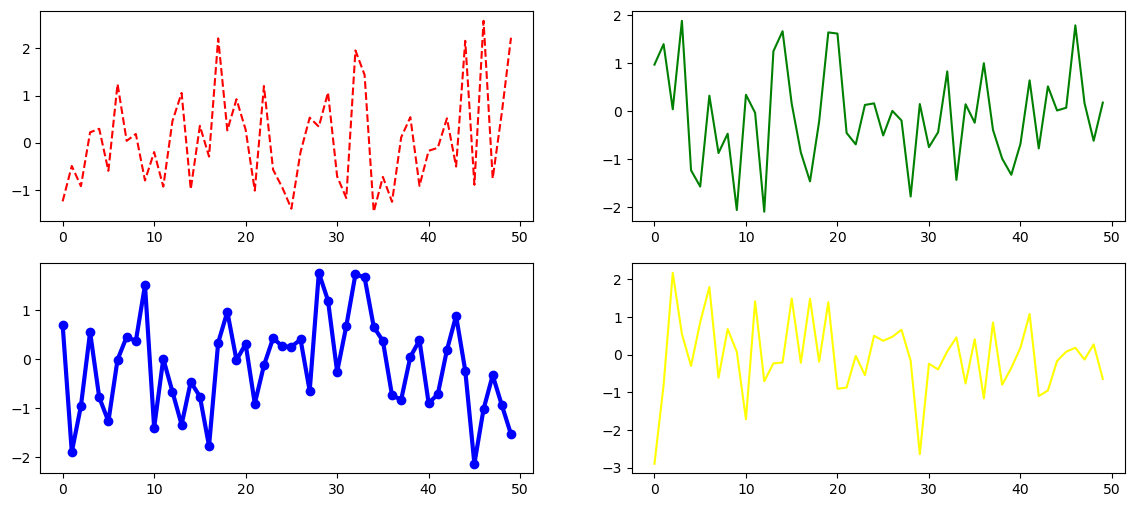

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import random 
x = np.arange(-10,11)
# fig, axes = plt.subplots(figsize= (12,6))
# axes.plot(x, x+0, linestyle = 'solid')
# axes.plot(x, x+1, linestyle = 'dashed')
# axes.plot(x, x+2, linestyle = 'dashdot')
# axes.plot(x, x+3, linestyle = 'dotted')
# axes.set_title('My Nice plot')
 
plot_object = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 6))

fig, ((ax1, ax2), (ax3, ax4)) = plot_object
ax1.plot(np.random.randn(50), c = 'red', linestyle = '--')
ax2.plot(np.random.randn(50), c = 'green', linestyle = '-')
ax3.plot(np.random.randn(50), c = 'blue', marker = 'o', linewidth = 3.0)
ax4.plot(np.random.randn(50), c = 'yellow')

print(plot_object[1])